In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alphabet/train.csv
/kaggle/input/alphabet/test.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for handling imbalancing
from imblearn.under_sampling import NearMiss
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix

import tensorflow as tf
import cv2
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold


import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.layers import Dropout

# for learning rate decay
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# **Alphabet Recognizer**
# Problem Statement
The input training dataset contains 28x28 pixel 297960 sample handwritten alphabets. It is represented by 784 features(columns) in the input dataset. The input dataset as well contains the target alphabet value (as numbers from 0..25) as a separate column ( in addition to 784 features columns).

The ask is to train a model and use it to predict handwritten alphabets for a test data set having 74490 sample images.
An output csv file is generated for test data set predictions using the best configured model.



# Solution Steps
This solution requires multi-class classification (26 alphabets). We have used a simple trial CNN to start with and we created a final CNN model after parameter tuning.
1. Read Data set
1. Examine Data set Properties
1. Inspecting the Dataframe
1. Data Preparation
    1. Copy Target Column(Alphabet) values and Remove from Training Data set
	1. Validate Training Sample size per Alphabet 
    1. Under sampling of Training dataset to balance class distribution
    1. Normalize Training dataset
    1. Reshape Training dataset for CNN Model
    1. Encode Target Variable
1. Model Creation
    1. Test-Train Split ( Training data set split into training, test(validation) dataset)
    1. Trial CNN 
        1. Model Definition
        1. Model Training / Fit
        1. Model Evaluation againt Validation
    1. Grid Search for Model Parameters
        1. Fully connected - Dense Layers and Neurons
        1. Batch size for training(fit)
        1. Drop out ratio for training(fit)
    1. Final Model
    1. Making predictions on the test set and Evaluation
    1. Saving the output prediction file


# Read Training Data set

In [3]:
df_train = pd.read_csv('/kaggle/input/alphabet/train.csv')

# Examine Training Dataset Properties

In [4]:
#find the rows x columns
df_train.shape

(297960, 785)

# Inspecting the Dataframe


In [5]:
#see the first 10 rows
df_train.head(10)

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#see the last 10 rows
df_train.tail()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
297955,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297956,24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297957,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297958,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297959,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Preparation

  ### Copy Target Column(Alphabet) values and Remove from Training Data set


In [7]:
#create target variable y for the alphabet dataset
y_train = df_train['0']

#remove target column from the df_alpha
del df_train['0']

In [8]:
# Rename values
alphabet_y_train = y_train.replace([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25], ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])


In [9]:
#view mapping 
alphabet_y_train

0         B
1         S
2         B
3         S
4         S
         ..
297955    S
297956    Y
297957    N
297958    O
297959    N
Name: 0, Length: 297960, dtype: object

 ### Validate Training Sample size per Alphabet 

<Figure size 1000x500 with 0 Axes>

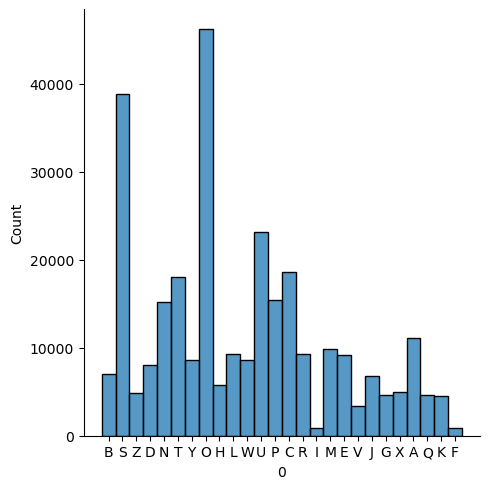

In [10]:
# Looking for imbalances in data
plt.figure(figsize = (10,5))
sns.displot(alphabet_y_train)

### Under sampling of Training dataset to balance class distribution

In [11]:
#undersample and balance samples per alphabet equally (~883 images per alphabet as outcome)
nM = NearMiss()
X_train_data, y_train_data = nM.fit_resample(df_train, y_train)

<Figure size 1000x500 with 0 Axes>

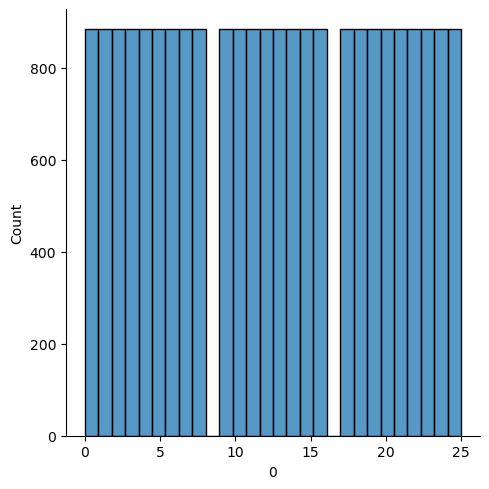

In [12]:
#visualize the distribution of the class after balancing
plt.figure(figsize = (10,5))
sns.displot(y_train_data)

In [13]:
#shape of the updated training dataset
y_train_data.shape , X_train_data.shape

((22958,), (22958, 784))

###     Normalize Training dataset


In [14]:
#normalize the training data set values
X_train_data = X_train_data / 255
X_train_data

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Reshape Training dataset for CNN Model 

In [15]:
#reshape datset
X_train_data = np.array(X_train_data)
X_train_data = X_train_data.reshape(-1,28,28,1)


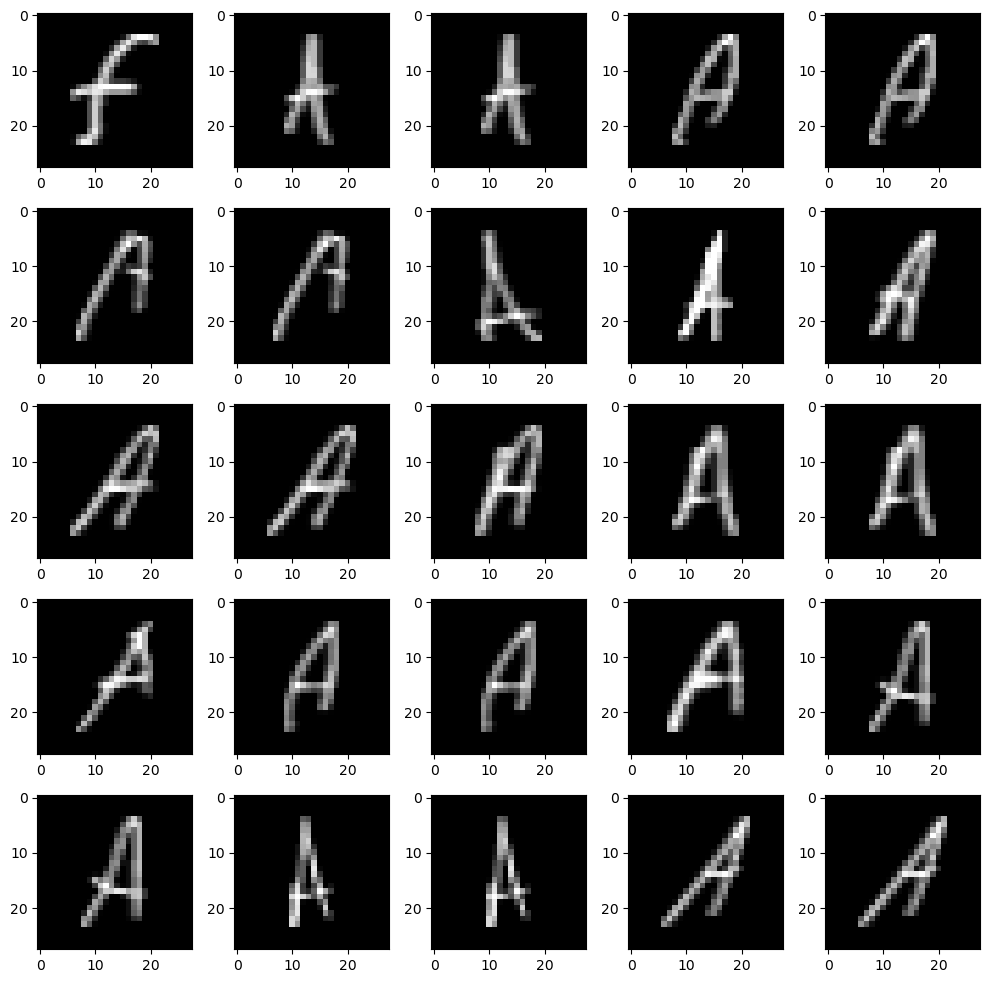

In [16]:
# view some of the handwritten alphabet images
f, ax = plt.subplots(5,5)
f.set_size_inches(10,10)
k = 0
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(X_train_data[k].reshape(28,28), cmap='gray')
        k += 1
    plt.tight_layout()

### Encode Target Variable

In [17]:
#One-Hot-Encoding of the target.
y = np_utils.to_categorical(y_train_data)
# Define the classification of 26 alphabets.
num_classes = y.shape[1]
num_classes

26

### Test-Train Split ( Training data set split into training, test(validation) dataset)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_train_data, y, test_size=0.2 ,random_state=102)


In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18366, 28, 28, 1), (4592, 28, 28, 1), (18366, 26), (4592, 26))

### Trial CNN
#### Model Definition

In [20]:
#Build an ordinary trial CNN model
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
#Choose an optimizer and compile the model.
model.compile(optimizer = Adam(learning_rate = 0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])
#And print the summary of the model.
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 128)               589952    
                                                                 
 dense_1 (Dense)             (None, 26)                3354      
                                                                 
Total params: 594,138
Trainable params: 594,138
Non-trainable params: 0
__________________________________________________

In [21]:
def model_fit_history_plot(history):
    plt.figure(1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['training','validation'])
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.figure(2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['training','validation'])
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.show()
    return None

#### Model Training / Fit

In [22]:
#train and fit the defined model for training / validation data sets
history = model.fit(X_train,y_train,epochs=15, batch_size=128, validation_data=(X_test,y_test))



Epoch 1/15
144/144 [==============================] - 7s 41ms/step - loss: 0.4997 - accuracy: 0.8583 - val_loss: 0.1964 - val_accuracy: 0.9438
Epoch 2/15
144/144 [==============================] - 5s 36ms/step - loss: 0.1238 - accuracy: 0.9646 - val_loss: 0.1647 - val_accuracy: 0.9571
Epoch 3/15
144/144 [==============================] - 5s 36ms/step - loss: 0.0668 - accuracy: 0.9796 - val_loss: 0.1519 - val_accuracy: 0.9617
Epoch 4/15
144/144 [==============================] - 5s 35ms/step - loss: 0.0573 - accuracy: 0.9816 - val_loss: 0.1703 - val_accuracy: 0.9588
Epoch 5/15
144/144 [==============================] - 5s 35ms/step - loss: 0.0403 - accuracy: 0.9861 - val_loss: 0.1273 - val_accuracy: 0.9747
Epoch 6/15
144/144 [==============================] - 5s 35ms/step - loss: 0.0261 - accuracy: 0.9923 - val_loss: 0.1551 - val_accuracy: 0.9702
Epoch 7/15
144/144 [==============================] - 5s 37ms/step - loss: 0.0421 - accuracy: 0.9874 - val_loss: 0.1537 - val_accuracy: 0.9647

#### Model Evaluation againt Validation

CNN Error: 3.09%


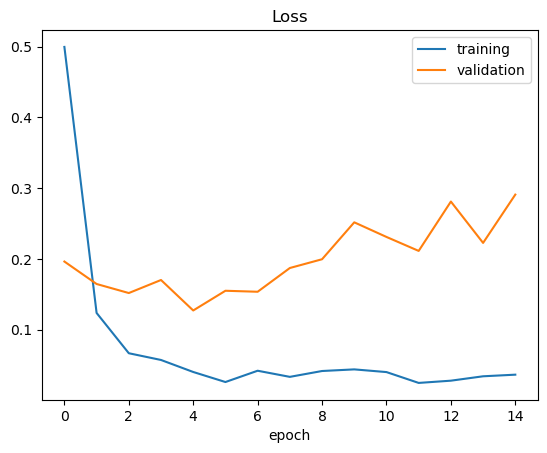

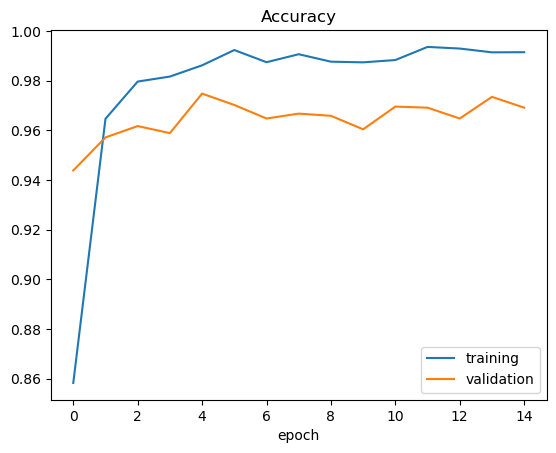

In [23]:
# evaluation of the model
scores = model.evaluate(X_test,y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

#Plot fit history
model_fit_history_plot(history)

### Grid Search for Model Parameters

#### Fully connected - Dense Layers and Neurons

In [24]:
# Grid Search to determine the layers and neurons in each layer in the sequential model.
def create_model(layers):
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[28, 28, 1]))
    cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
    cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn_model.add(tf.keras.layers.Flatten())
    
    for i, nodes in enumerate(layers):
        cnn_model.add(tf.keras.layers.Dense(units=nodes, activation='relu'))
            
    cnn_model.add(tf.keras.layers.Dense(units=26, activation='softmax'))
    
    cnn_model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return cnn_model

model = KerasClassifier(build_fn=create_model, verbose=1)
layers = [[128],(128,64),(256, 128),(256, 128, 64)]
param_grid = dict(layers=layers)
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=1)
grid_results = grid.fit(X_train,y_train, validation_data=(X_test, y_test))
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))
best_layer_size=grid_results.best_params_['layers']  
    

Fitting 5 folds for each of 4 candidates, totalling 20 fits
574/574 [==============================] - 13s 20ms/step - loss: 0.0692 - accuracy: 0.7139 - val_loss: 0.0260 - val_accuracy: 0.9090
Best: 0.8835341215133667, using {'layers': (256, 128)}
0.8663299083709717 (0.01645192867392345) with: {'layers': [128]}
0.8495576739311218 (0.019914395237431173) with: {'layers': (128, 64)}
0.8835341215133667 (0.008807114635179365) with: {'layers': (256, 128)}
0.8777074933052063 (0.01775907264282626) with: {'layers': (256, 128, 64)}


#### Batch size for training(fit)

In [25]:
#Grid Search to determine the batch size
def create_model1():
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[28, 28, 1]))
    cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
    cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(units=256, activation='relu'))
    cnn_model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    cnn_model.add(tf.keras.layers.Dense(units=26, activation='softmax'))
    
    cnn_model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return cnn_model

model = KerasClassifier(build_fn = create_model1, verbose = 1)

batch_size = [15,20,40,50]
param_grid = dict(batch_size=batch_size)

grid = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 1)
grid_results = grid.fit(X_train,y_train, validation_data=(X_test, y_test))

print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
params = grid_results.cv_results_['params']
for mean,param in zip(means,params):
    print('{0} with: {1}'.format(mean,param))
best_batch_size=grid_results.best_params_['batch_size']

Fitting 5 folds for each of 4 candidates, totalling 20 fits
1225/1225 [==============================] - 18s 14ms/step - loss: 0.0494 - accuracy: 0.7853 - val_loss: 0.0195 - val_accuracy: 0.9329
Best: 0.9213760018348693, using {'batch_size': 15}
0.9213760018348693 with: {'batch_size': 15}
0.9108683705329895 with: {'batch_size': 20}
0.8799961805343628 with: {'batch_size': 40}
0.8546223282814026 with: {'batch_size': 50}


#### Drop out ratio for training(fit)

In [26]:
#Grid Search to determine the dropout rate

def create_model2(dropout):
    # create model
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[28, 28, 1]))
    cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
    cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(units=best_layer_size[0], activation='relu'))
    cnn_model.add(Dropout(dropout))
    cnn_model.add(tf.keras.layers.Dense(units=best_layer_size[1], activation='relu'))
    cnn_model.add(Dropout(dropout))
    cnn_model.add(tf.keras.layers.Dense(units=26, activation='softmax'))
    
    cnn_model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return cnn_model

model = KerasClassifier(build_fn = create_model2, verbose = 1, batch_size=best_batch_size)

dropout = [0.0, 0.1, 0.2]
param_grid = dict(dropout=dropout)

grid = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 1)
grid_results = grid.fit(X_train,y_train, validation_data=(X_test, y_test))

print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
params = grid_results.cv_results_['params']
for mean,param in zip(means,params):
    print('{0} with: {1}'.format(mean,param))
best_dropout_rate=grid_results.best_params_['dropout']

Fitting 5 folds for each of 3 candidates, totalling 15 fits
1225/1225 [==============================] - 18s 14ms/step - loss: 0.0568 - accuracy: 0.7534 - val_loss: 0.0180 - val_accuracy: 0.9297
Best: 0.9305235028266907, using {'dropout': 0.1}
0.9233912229537964 with: {'dropout': 0.0}
0.9305235028266907 with: {'dropout': 0.1}
0.9205049753189087 with: {'dropout': 0.2}


### Final Model

Epoch 1/20
1225/1225 [==============================] - 18s 14ms/step - loss: 0.0575 - accuracy: 0.7476 - val_loss: 0.0173 - val_accuracy: 0.9325
Epoch 2/20
1225/1225 [==============================] - 16s 13ms/step - loss: 0.0147 - accuracy: 0.9449 - val_loss: 0.0106 - val_accuracy: 0.9597
Epoch 3/20
1225/1225 [==============================] - 17s 13ms/step - loss: 0.0094 - accuracy: 0.9663 - val_loss: 0.0084 - val_accuracy: 0.9682
Epoch 4/20
1225/1225 [==============================] - 17s 14ms/step - loss: 0.0069 - accuracy: 0.9742 - val_loss: 0.0076 - val_accuracy: 0.9719
Epoch 5/20
1225/1225 [==============================] - 17s 14ms/step - loss: 0.0053 - accuracy: 0.9814 - val_loss: 0.0066 - val_accuracy: 0.9776
Epoch 6/20
1225/1225 [==============================] - 17s 14ms/step - loss: 0.0044 - accuracy: 0.9841 - val_loss: 0.0063 - val_accuracy: 0.9769
Epoch 7/20
1225/1225 [==============================] - 16s 13ms/step - loss: 0.0036 - accuracy: 0.9870 - val_loss: 0.0062 -

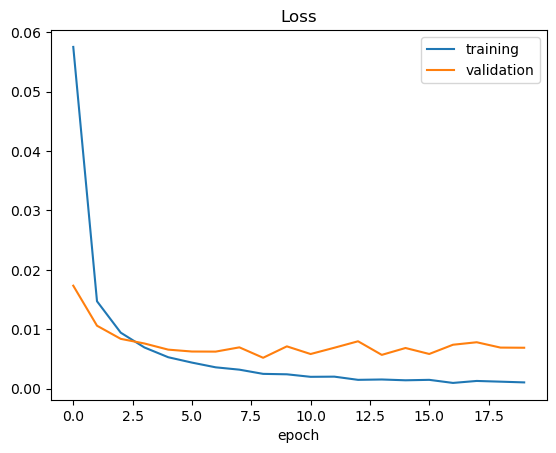

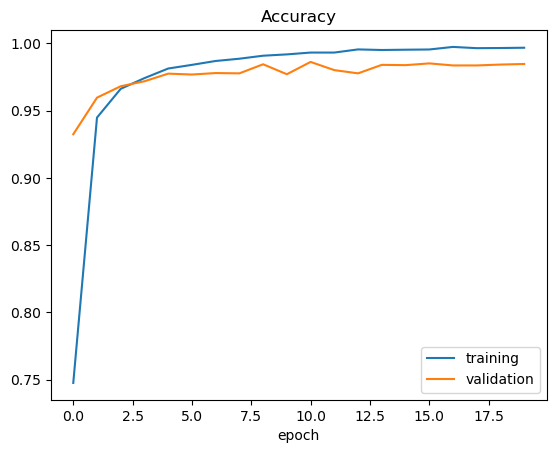

In [27]:
#Definition of the final CNN model

cnn_model = tf.keras.models.Sequential()
cnn_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[28, 28, 1]))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
cnn_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(units=best_layer_size[0], activation='relu'))
cnn_model.add(Dropout(best_dropout_rate))
cnn_model.add(tf.keras.layers.Dense(units=best_layer_size[1], activation='relu'))
cnn_model.add(Dropout(best_dropout_rate))
cnn_model.add(tf.keras.layers.Dense(units=26, activation='softmax'))

# compile the model
cnn_model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = cnn_model.fit(X_train, y_train, batch_size=best_batch_size, epochs=20,validation_data=(X_test, y_test))


# Final evaluation of the model
scores = cnn_model.evaluate(X_test,y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

#Plot fit history
model_fit_history_plot(history)

### Making predictions on the test set and Evaluation


In [28]:
# read test dataset
df_test = pd.read_csv('/kaggle/input/alphabet/test.csv')

In [29]:
# Test dataset properties
df_test.shape

(74490, 785)

In [30]:
# Explore test dataset
df_test.head(10)

,Unnamed: 0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
#find the rows x columns
df_test.columns

Index(['Unnamed: 0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8',
       '0.9',
       ...
       '0.639', '0.640', '0.641', '0.642', '0.643', '0.644', '0.645', '0.646',
       '0.647', '0.648'],
      dtype='object', length=785)

In [32]:
#check if the first column is target variable?
y_test = df_test['Unnamed: 0']

In [33]:
#first column is not representing the alphabet  and so in the test data set there is target variable column
#we can safely ignore this variable!
y_test.unique()

array([    0,     1,     2, ..., 74487, 74488, 74489])

In [34]:
# Create the pandas DataFrame
#df_result = pd.DataFrame(data, columns=['ID', 'Prediction'])
#df_result['ID']= df_test['Unnamed: 0']

#remove first column from df_test
del df_test['Unnamed: 0'] 

In [35]:
#normalization - ADHARSH to test different techniques
X_test_data = df_test / 255
X_test_data

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


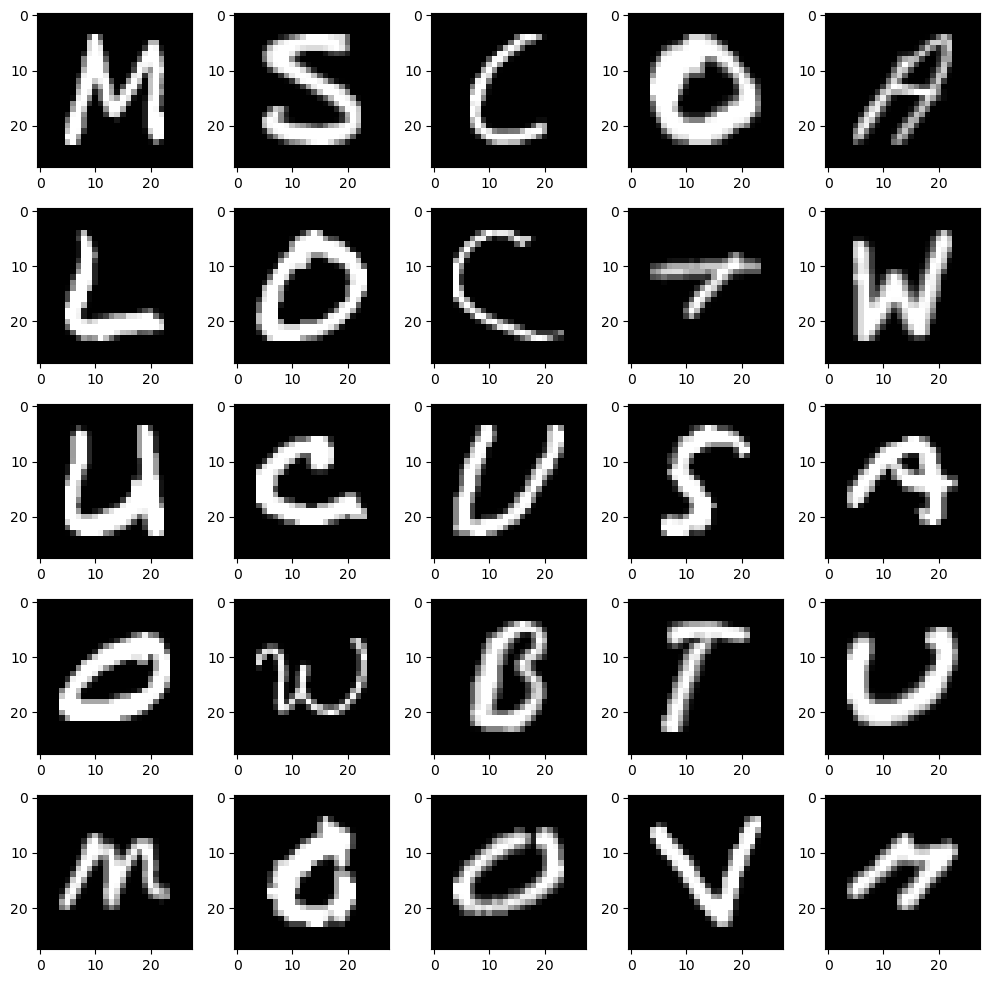

In [36]:
#convert to numpy array
X_test_data = np.array(X_test_data)
X_test_data = X_test_data.reshape(-1,28,28,1)
# Showing few images
f, ax = plt.subplots(5,5)
f.set_size_inches(10,10)
k = 0
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(X_test_data[k].reshape(28,28), cmap='gray')
        k += 1
    plt.tight_layout()

In [37]:
#predict target variable (alphabet) using the CNN model
y_pred=cnn_model.predict(X_test_data)

2328/2328 [==============================] - 13s 6ms/step


In [38]:
#check prediction shape
y_pred.shape

(74490, 26)

y_pred has 26 columns for all the rows; each column represents the probability of a letter for that row. The next line of code find the the column that has the max value and then puts that column as  value into the predictions variable I think. Adharsh to validate!

In [39]:
#creating our predictions using the pixel values; #
# taking the largest number column value as the result from
predictions = np.argmax(y_pred,axis = 1)

In [40]:
#validate the shape of the predictions
predictions.shape

(74490,)

In [41]:
#convert numpy array to dataframe
df_predictions = pd.DataFrame(predictions, columns = ['alphabet'])

In [42]:
#replace numbers with alphabet
alphabet_y_test = df_predictions.replace([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25], ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])

In [43]:
#view the predictions
alphabet_y_test

,alphabet
0,M
1,S
2,C
3,Q
4,A
...,...
74485,N
74486,G
74487,J
74488,M


### Saving the output prediction file

In [44]:
#save to CSV Result
alphabet_y_test.to_csv('TestDataset_Prediction.csv')